In [ ]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
""" 
Main data
"""
sub_path = "C:/Users/mvmigem/Documents/data/project_1/uncorrected_rERPs/"
dir_list = glob.glob(sub_path+'/*.csv')
loaded_dfs = []
roi_channels = ['Oz','O1','O2',
                'PO3','POz','PO4',
                'P1','Pz','P2',
                'CP1','CPz','CP2',
                'PO8','PO7','P4','P3',
                'C5','C3','CP5','CP3',
                'C4','C6','CP4','CP6',
                ]

for p in dir_list:
    df_sub = pd.read_csv(p)
    df_sub = df_sub[df_sub['channel'].isin(roi_channels)]
    loaded_dfs.append(df_sub)

df = pd.concat(loaded_dfs,ignore_index=True)
# Drop non EEG channels
df = df[~df['channel'].isin(['eye_above','eye_below','eye_left','eye_right','Status'])]
max_time = .6 # change this depending on the ERP you want to look at
df = df[df['time'] < max_time]

In [ ]:
peak_prop_path = "C:/Users/mvmigem/Documents/data/project_1/compiled_dataframes/c1_peak_properties.csv"
peak_prop = pd.read_csv(peak_prop_path)
best_pairs = list(zip(peak_prop['subject'], peak_prop['all_pos_peak_channel']))
df['selected_ch'] = df[['subject', 'channel']].apply(tuple, axis=1).isin(best_pairs)
df['visual_field'] = np.where(df['position'].isin([1, 2]), 'up', 'down')

In [ ]:
baseline_period = df['time'] <0
baseline_means = df[baseline_period].groupby(['subject','channel','visual_field','attention','expectation'])['yhat'].mean() #,'visual_field'

df['y_bc'] = df.apply(
    lambda row: row['yhat'] - baseline_means[(row['subject'],row['channel'],row['visual_field'], row['attention'], row['expectation'])], #,row['visual_field']
    axis=1
)

In [ ]:
line_colours1= ['#219EBC','#FFB703']
line_colours2 = ['#8ECAE6','#FB8500',]
line_colours = ['#219EBC','#FFB703','#8ECAE6','#FB8500']

side = 'down'
y = 'y_bc'

fig, ax = plt.subplots(1,1,sharey=False,sharex=False)
sns.lineplot(data=df[df['selected_ch']][df['visual_field']=='up'],
            x='time',y= y,
            hue='attention',style='expectation',
            palette=line_colours1, errorbar='se')

sns.lineplot(data=df[df['selected_ch']][df['visual_field']=='down'],
            x='time',y= y,
            hue='attention',style='expectation',
            palette=line_colours2,errorbar='se')

ax.axhline(y=0, lw=1, c='black' )
ax.axvline(x=0.1, lw=1, c='black' )

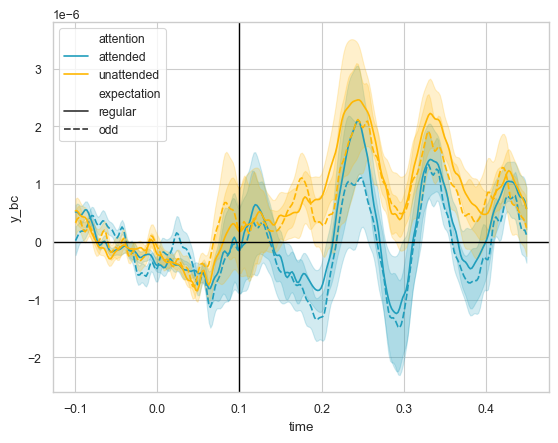

In [13]:

line_colours1= ['#219EBC','#FFB703']
line_colours2 = ['#8ECAE6','#FB8500',]

side = 'down'
y = 'y_bc'

fig, ax = plt.subplots(1)

sns.lineplot(data=df[df['channel'].isin(["PO8","PO4","O2","PO8","PO4","O2"])],
            x='time',y=y,
            hue='attention',style='expectation',
            palette=line_colours1,
            errorbar='se')

ax.axhline(y=0, lw=1, c='black' )
ax.axvline(x=0.1, lw=1, c='black' )

In [ ]:
""" 
Select the C1 to analyse
"""
peak_properties = pd.read_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_peak_properties.csv')
##  C1 time window
# Window search
c1_tmin = 0.06
c1_tmax = 0.09
c1_timwid = 0.01
c1_sampwid = int(c1_timwid*512)

subject_list = df['subject'].unique()
winidx_c1 = []
df_1 = df[df['channel'] == 'POz'].reset_index()
df_2 = df[df['selected_ch']].reset_index()
for n,df in enumerate([df_1,df_2]):
    indexes_peak = []
    for sub in subject_list:
        sub_df = df[df['subject']== sub]
        peak_time = peak_properties[peak_properties['subject'] == sub]['all_pos_peak_latency'].iloc[0]
        peak_indx = np.array(sub_df[sub_df['time'] == peak_time]['index'])
        indexes_peak = np.concatenate([indexes_peak,peak_indx],axis=0)
    # Select window around it
    winidx_c1_n = []
    for i, idx in enumerate(indexes_peak):
        win_li = np.arange(idx - c1_sampwid, idx + c1_sampwid +1)
        winidx_c1_n = np.concatenate([winidx_c1_n,win_li],axis=0)
    winidx_c1.append(winidx_c1_n)

winidx_c1_1 = winidx_c1[0].astype(int)
winidx_c1_2 = winidx_c1[1].astype(int)
# Apply to df
c1_win_df_1 = df_1[df_1['index'].isin(winidx_c1_1)]
c1_means_df_1 = c1_win_df_1.groupby(['subject','attention','expectation','visual_field'])['y_bc'].mean().reset_index()

# Apply to df
c1_win_df_2 = df_2[df_2['index'].isin(winidx_c1_2)]
c1_means_df_2 = c1_win_df_2.groupby(['subject','attention','expectation','visual_field'])['y_bc'].mean().reset_index()

In [ ]:
sns.set_style('whitegrid')
sns.set_context("paper")

line_colours1= ['#219EBC','#FFB703','#8ECAE6','#FB8500',]

g = sns.catplot(data= c1_means_df_1, y = 'y_bc', x = 'attention',
            hue = 'expectation', col = 'visual_field',
            kind = 'bar',
            edgecolor= 'black',
            errorbar='se',
            linewidth=0.7, 
            palette=line_colours1)
g = sns.catplot(data= c1_means_df_2, y = 'y_bc', x = 'attention',
            hue = 'expectation', col = 'visual_field',
            kind = 'bar',
            edgecolor= 'black',
            errorbar='se',
            linewidth=0.7, 

            palette=line_colours1)

plt.show()

In [ ]:
import seaborn.objects as so

(
    so.Plot(c1_means_df_1, x="attention", y="y_bc",color="expectation")
    .facet(row="visual_field")
    .add(so.Bar(),so.Agg(),so.Dodge())
    .share(y=False)
    .add(so.Range(), so.Est(errorbar='se'),so.Dodge())  # Adds error bars as ranges
)

In [ ]:
destination_folder = r"C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes/"
c1_means_df_1['amp'] = c1_means_df_1['y_bc'] * 1e6
c1_means_df_2['amp'] = c1_means_df_1['y_bc'] * 1e6
c1_means_df_2.to_csv(destination_folder + "uc_rerp_c1_var_df.csv")
c1_means_df_1.to_csv(destination_folder + "uc_rerp_c1_fix_df.csv")